In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
def getDataFrame(url):
    data = requests.get(url).json()
    data = data['value']
    data = pd.DataFrame(data)
    return data

In [3]:
def Integrity_Check(df):
    print('Is there any null value in the dataset')
    print(df.isna().all().all())
    print('Every year has all country data?')
    print(df.groupby(['year'])['countryCode'].nunique())
    print('which country provide more data?')
    print(df.groupby(['countryCode'])['year'].count().sort_values(ascending=False))
    print('How many cause of death in the dataset? Any herirarchy?')
    print(list[df['diseaseName'].unique()])
    print('which cause of death has more country data? ')
    print(df.groupby(['diseaseName'])['countryCode'].nunique().sort_values(ascending=False))


In [4]:

def world_mortality_trend(all_data):
    worldly_mortality_trend=all_data.groupby(['year','countryCode'],as_index=False)[['population','deathNum']].agg({'population':np.max,'deathNum': np.sum})
    worldly=worldly_mortality_trend.groupby(['year'],as_index=False)[['population','deathNum']].agg({'population':np.sum, 'deathNum': np.sum})
    worldly['death_per1000']=worldly['deathNum']/worldly['population']*1000

    fig = plt.figure(figsize = (14,7))
    plt.plot(worldly['year'],
         worldly['death_per1000'],
         linestyle = '-',
         linewidth = 2,
         color = 'steelblue',

         markeredgecolor='black',
         markerfacecolor='brown')

    plt.title('Globally mortality rate')
    plt.xlabel('Year')
    plt.ylabel('rate( per 1000 population)')
    plt.ylim((4, 10))
    plt.xticks(range(2000,2020,1))
    return worldly


In [5]:

def ratetrend_incomegroup(dataset):#done
    causebyincome=dataset.sort_values(['deathNum'],ascending=False).groupby(['incomeGroup','year','countryCode'],as_index=False)[['population','deathNum']].agg({'population':np.max,'deathNum': np.sum})
    causebyincome=causebyincome.groupby(['incomeGroup','year'],as_index=False)[['population','deathNum']].agg({'population':np.sum, 'deathNum': np.sum})
    causebyincome['death_per1000']=causebyincome['deathNum']/causebyincome['population']*1000
    causebyincome=causebyincome[causebyincome['incomeGroup']!='..']
    return causebyincome



In [6]:

def Topdeathtype_incomegroup_year(dataset,  year):   #done
    causebyincome=dataset[(dataset['year']==year)].sort_values(['deathNum'],ascending=False).groupby(['incomeGroup','mortality_type','countryCode'],as_index=False)[['population','deathNum']].agg({'population':np.max,'deathNum': np.sum})

    causebyincome1=causebyincome.groupby(['incomeGroup','mortality_type'],as_index=False)[['population','deathNum']].agg({'population':np.sum, 'deathNum': np.sum})
    causebyincome1['death_per1000']=causebyincome1['deathNum']/causebyincome1['population']*1000
    causebyincome1=causebyincome1[causebyincome1['incomeGroup']!='..']
    causebyincome1 = causebyincome1.pivot(index='incomeGroup', columns='mortality_type', values='death_per1000')
    colors = ["#006D2C", "#31A354","#74C476"]
    causebyincome1.loc[:,['Injuries','communicable', 'noncommunicable']].plot.bar(stacked=True, color=colors, figsize=(10,7),ylim=([0,10]))
    return causebyincome1

In [7]:
def Topcause_trend(dataset,year,income_group='All',category='All'):
    top10cause=Topcause_year(dataset,year,income_group,category)
    disease_list=list(top10cause['diseaseName'])

    if income_group=='All':
        incomegroup=['H','L','UM','LM']
    else:
        incomegroup=[income_group]
    if category=='All':
        mortalitycategory=['communicable','noncommunicable','Injuries']
    else:
        mortalitycategory=[category]

    df=dataset[(dataset['incomeGroup'].isin(incomegroup))&(dataset['mortality_type'].isin(mortalitycategory))&(dataset['diseaseName'].isin(disease_list))].groupby(['diseaseName','year','countryCode'],as_index=False)[['population','deathNum']].agg({'population':np.max,'deathNum': np.sum})

    df1=df.groupby(['diseaseName','year'],as_index=False)[['population','deathNum']].agg({'population':np.sum,'deathNum': np.sum})
    df1['death_per1000']=df1['deathNum']/df1['population']*1000
    df1 = df1.pivot(index='year', columns='diseaseName', values='death_per1000')
    plot=df1.plot(kind='line', xlabel='year',ylabel='the number of death per 1000 ',
                 title='Death rate trend from 2000-2019\nincome group='+income_group+' Mortality type='+category,
                 figsize=(10, 7),legend=True,xticks=(range(2000,2020,1)))
    plot.legend(bbox_to_anchor=(1.5, 1))

    return df1

In [8]:
def Topcause_year(dataset, year,income_group='All',category='All'):#done
    if income_group=='All':
        incomegroup=['H','L','UM','LM']
    else:
        incomegroup=[income_group]
    if category=='All':
        mortalitycategory=['communicable','noncommunicable','Injuries']
    else:
        mortalitycategory=[category]

    df=dataset[(dataset['year']==year)&(dataset['incomeGroup'].isin(incomegroup))&(dataset['mortality_type'].isin(mortalitycategory))].sort_values(['deathNum'],ascending=False).groupby(['diseaseName'],as_index=False)[['deathNum','mortality_type']].agg({'deathNum': np.sum,'mortality_type':np.max}).nlargest(10,'deathNum')

    plt.bar(df['diseaseName'],df['deathNum'])
    plt.xticks(rotation=270)
    plt.title('10 leading disease\n income group='+income_group+', Mortality type='+category)
    plt.xlabel('Disease')
    plt.ylabel('Number of death')
    plt.show()
    return df

In [9]:
def deathtypetrend(dataset, income_group='ALL'):
    if income_group=='ALL':
        incomegroup=['..','H','L','UM','LM']
    else:
        incomegroup=[income_group]
    causebyincome=dataset[dataset['incomeGroup'].isin(incomegroup)].sort_values(['deathNum'],ascending=False).groupby(['year','mortality_type','countryCode'],as_index=False)[['population','deathNum']].agg({'population':np.max,'deathNum': np.sum})

    causebyincome1=causebyincome.groupby(['year','mortality_type'],as_index=False)[['population','deathNum']].agg({'population':np.sum, 'deathNum': np.sum})
    causebyincome1['death_per1000']=causebyincome1['deathNum']/causebyincome1['population']*1000
    causebyincome1 = causebyincome1.pivot(index='year', columns='mortality_type', values='death_per1000')
    causebyincome1.plot(kind='line', xlabel='year',ylabel='death_per1000',
                 title='three causes of death trend from 2000-2019 in the income_group='+income_group,
                 figsize=(10, 7),legend=True,xticks=(range(2000,2020,1)))
    return causebyincome1

In [10]:
def lineplot_time(HealthOutcomeData):
    """
    :param HealthOutcomeData: data set of health outcome data: Under5_Mortality, LifeExpectancy
    :return:

    >>>

    """
    b = HealthOutcomeData[(HealthOutcomeData['Dim1'] == 'BTSX') & (HealthOutcomeData['SpatialDimType'] == 'REGION')][['TimeDim','NumericValue','SpatialDim']]
    a = b[b['SpatialDim'] != 'GLOBAL'] # no global value
    a = a.astype({"TimeDim": str})
    a = a.pivot(index='TimeDim', columns='SpatialDim',values = 'NumericValue')
    a = a.rename_axis(None, axis=1)
    p = sns.lineplot(data=a)
    p.set( xlabel = "Year", ylabel = 'Value')

In [11]:
def formatWithSex(name, df):
    """
    only applies to life expectancy and Under5_Mortality
    :param name: reformat with sex, pivot that column
    :param df:
    :return:
    """
    df = df[df['SpatialDimType'] == 'COUNTRY']
    df = df[['SpatialDim','TimeDim','Dim1','NumericValue']]
    df = df.rename(columns={"SpatialDim":"countrycode", "TimeDim":"year", "Dim1":"Sex","NumericValue": 'df'})
    df = df.pivot(index=['countrycode','year'],columns = ['Sex'],values= 'df')
    df = df.reset_index()
    df.rename(columns={'BTSX':f'{name}_BTSX','FMLE':f'{name}_FMLE','MLE':f'{name}_MLE'},inplace=True)
    df = df[['countrycode','year',f'{name}_BTSX',f'{name}_FMLE',f'{name}_MLE']]
    df = df.rename_axis(None, axis=1) # remove "Sex" as the index name
    return df

In [12]:
def formatWithoutSex(df):
    df = df[df['SpatialDimType'] == 'COUNTRY']
    df = df[['SpatialDim','TimeDim','NumericValue']]
    df = df.rename(columns={"SpatialDim":"countrycode", "TimeDim":"year", "NumericValue": 'MaternalMortalityRatio'})
    df = df.astype({"year": str})
    df = df[['countrycode','year','MaternalMortalityRatio']]
    return df

In [13]:
def effectOfexp2015before(data,col,region):
    if region not in ['East Asia & Pacific','Europe & Central Asia','Latin America & Caribbean','Middle East & North Africa','North America','South Asia','Sub-Saharan Africa']:
        return
    cleaned = data.loc[(data["Year"] == 2000) | (data["Year"] == 2001) | (data["Year"] == 2002) | (data["Year"] == 2003) | (data["Year"] == 2004) | (data["Year"] == 2005) | (data["Year"] == 2006) | (data["Year"] == 2007) | (data["Year"] == 2008) | (data["Year"] == 2009) | (data["Year"] == 2010) | (data["Year"] == 2011) | (data["Year"] == 2012) | (data["Year"] == 2013) | (data["Year"] == 2014)]
    coefficient, pvalue = pearsonr(cleaned[cleaned['Region'] == region]['che_gdp'], cleaned[cleaned['Region'] == region][col])
    return coefficient, pvalue

In [14]:
# life expectancy: Europe & Central Asia positively correlated; Sub-Saharan Africa negatively correlated: differ in regions:
# year: before 2015 in Sub-Saharan Africa, 1 percent increase in health expenditure per capita improve life expectancy by 0.06 percent.
# in 2019: sub-Saharan Africa, 1 percent increase in health expenditure per capita improve life expectancy by 0.06 percent.
def effectOfexp2015after(data,col,region):
    if region in ['East Asia & Pacific','Europe & Central Asia','Latin America & Caribbean','Middle East & North Africa','North America','South Asia','Sub-Saharan Africa']:
        cleaned = data.loc[(data["Year"] == 2015) | (data["Year"] == 2016) | (data["Year"] == 2017) | (data["Year"] == 2018) | (data["Year"] == 2019)]
        coefficient, pvalue = pearsonr(cleaned[cleaned['Region'] == region]['che_gdp'], cleaned[cleaned['Region'] == region][col])
        return coefficient, pvalue
    else:
        return
# effectOfexp(MaternalMortality_clean,'MaternalMortalityRatio')

In [25]:
#
LifeExpectancy_1 = getDataFrame('https://ghoapi.azureedge.net/api/WHOSIS_000001')
Under5_Mortality_1 = getDataFrame('https://ghoapi.azureedge.net/api/MDG_0000000007')
MaternalMortalityRatio_1 = getDataFrame('https://ghoapi.azureedge.net/api/MDG_0000000026')
global_data=getDataFrame('https://frontdoor-l4uikgap6gz3m.azurefd.net/DEX_CMS/GHE_FULL?&$orderby=VAL_DEATHS_RATE100K_NUMERIC%20desc&$select=DIM_COUNTRY_CODE,DIM_GHECAUSE_CODE,DIM_GHECAUSE_TITLE,DIM_YEAR_CODE,DIM_SEX_CODE,DIM_AGEGROUP_CODE,VAL_DALY_COUNT_NUMERIC,VAL_DEATHS_COUNT_NUMERIC,ATTR_POPULATION_NUMERIC,VAL_DALY_RATE100K_NUMERIC,VAL_DEATHS_RATE100K_NUMERIC&$filter=FLAG_RANKABLE%20eq%201%20and%20DIM_SEX_CODE%20eq%20%27BTSX%27%20and%20DIM_AGEGROUP_CODE%20eq%20%27ALLAges%27')

In [62]:
incomegroup = pd.read_excel("datasources/income group.xlsx",sheet_name='Sheet1')
region = pd.read_csv("datasources/country_region.csv")[['Country','Region']]
healthExp = pd.read_excel("datasources/healthExp_data.xlsx",sheet_name='cleaned')
healthExp = healthExp[['country','year','che_gdp']]



In [17]:

incomegroup = pd.melt(incomegroup, id_vars=['CountryCode','CountryName'], value_vars=[2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020], var_name='Year', value_name='incomeGroup')
# left join with region table.

countryInfo = incomegroup.merge(region, left_on='CountryName', right_on='Country') # inner join
countryInfo = countryInfo[['Country','CountryCode','Region','Year','incomeGroup']]
# merge datasets based on two columns:
countryInfoAll = countryInfo.merge(healthExp, left_on=['Country','Year'], right_on=['country','year']) # inner join
countryInfoAll = countryInfoAll[['Country','Region','CountryCode','Year','incomeGroup','che_gdp']]
countryInfoAll

,Country,Region,CountryCode,Year,incomeGroup,che_gdp
0,Afghanistan,South Asia,AFG,2000,L,NaN
1,Afghanistan,South Asia,AFG,2001,L,NaN
2,Afghanistan,South Asia,AFG,2002,L,9.443390
3,Afghanistan,South Asia,AFG,2003,L,8.941258
4,Afghanistan,South Asia,AFG,2004,L,9.808474
...,...,...,...,...,...,...
3275,Zimbabwe,Sub-Saharan Africa,ZWE,2015,L,7.452066
3276,Zimbabwe,Sub-Saharan Africa,ZWE,2016,L,7.675163
3277,Zimbabwe,Sub-Saharan Africa,ZWE,2017,L,7.469752
3278,Zimbabwe,Sub-Saharan Africa,ZWE,2018,LM,8.680062


In [30]:
global_data_1=global_data.rename(columns={"DIM_COUNTRY_CODE": "countryCode",
                          "DIM_YEAR_CODE":"year",
                          "ATTR_POPULATION_NUMERIC":"population",
                          "DIM_GHECAUSE_CODE":"diseaseCode",
                          "DIM_GHECAUSE_TITLE":"diseaseName",
                          "VAL_DEATHS_COUNT_NUMERIC":"deathNum"
                          })

global_data_1['diseaseCode']=global_data_1['diseaseCode'].astype('int')
global_data_1['year']=global_data_1['year'].astype('int')

global_data_1 = global_data_1.merge(countryInfo, how='left',left_on=['countryCode','year'],right_on=['CountryCode','Year'] ) # left join

global_data_1['mortality_type']=None
global_data_1.loc[global_data_1['diseaseCode']<600,'mortality_type']='communicable'
global_data_1.loc[(global_data_1['diseaseCode']>600) & (global_data_1['diseaseCode']<1510),'mortality_type']='noncommunicable'
global_data_1.loc[global_data_1['diseaseCode']>1510,'mortality_type']='Injuries'

In [31]:
global_data_1=global_data_1[['countryCode','Country','incomeGroup','year','population','mortality_type','diseaseCode','diseaseName','deathNum']]

In [32]:
Integrity_Check(global_data_1)

Is there any null value in the dataset
False
Every year has all country data?
year
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2013    183
2014    183
2015    183
2016    183
2017    183
2018    183
2019    183
Name: countryCode, dtype: int64
which country provide more data?
countryCode
RUS    927
SOM    901
CAF    884
UKR    879
LTU    879
      ... 
SAU    370
BHR    351
ARE    319
QAT    285
KWT    261
Name: year, Length: 183, dtype: int64
How many cause of death in the dataset? Any herirarchy?
list[array(['Natural disasters', 'HIV/AIDS', 'Ischaemic heart disease',
       'Collective violence and legal intervention', 'Stroke', 'Malaria',
       'Diarrhoeal diseases', 'Lower respiratory infections', 'Measles',
       'Hypertensive heart disease',
       'Cardiomyopathy, myocarditis, endocarditis',
       'Protein-energy malnutrition', 'Neonatal conditions',
       'Alzheime

,year,population,deathNum,death_per1000
0,2000,6.116994e+09,45387904.74,7.419969
1,2001,6.197259e+09,45587156.12,7.356020
2,2002,6.260956e+09,46009360.66,7.348616
3,2003,6.343724e+09,46220884.71,7.286081
4,2004,6.426602e+09,45919133.15,7.145165
5,2005,6.510923e+09,45712089.62,7.020831
6,2006,6.597804e+09,45309802.67,6.867406
7,2007,6.663735e+09,45261094.74,6.792151
8,2008,6.751347e+09,45671698.34,6.764827
9,2009,6.840801e+09,45021032.21,6.581251


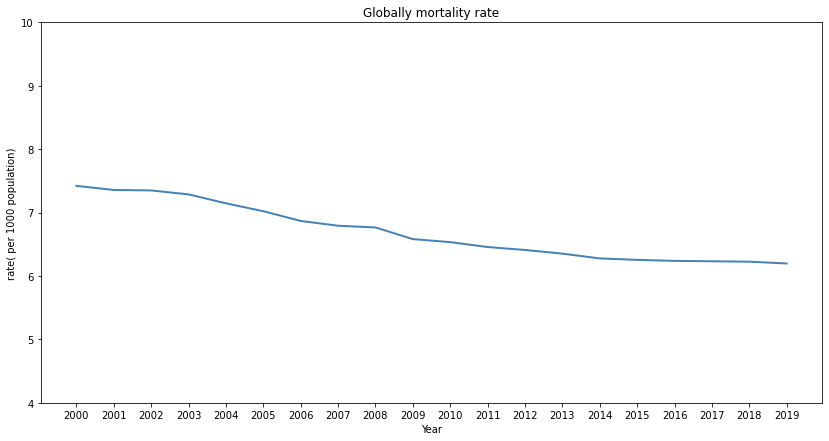

In [33]:
world_mortality_trend(global_data_1)

<AxesSubplot:title={'center':'death rate trend from 2000-2019 by income_group'}, xlabel='year', ylabel='death_per1000 '>

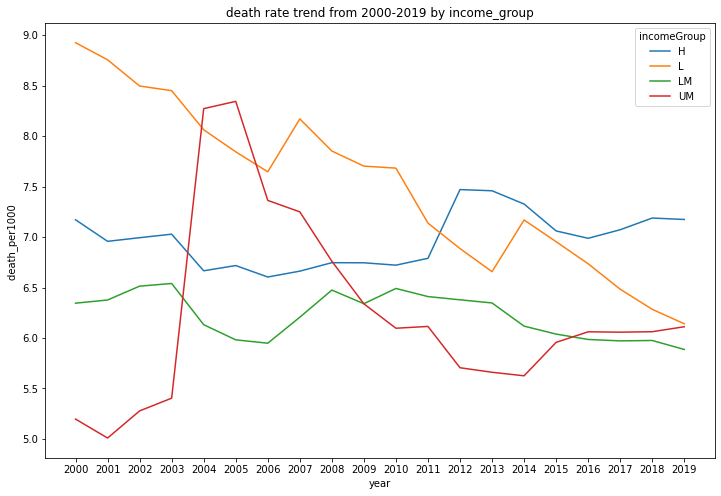

In [34]:
d=ratetrend_incomegroup(global_data_1)
plotdata=d.pivot(index='year', columns='incomeGroup', values='death_per1000')
plotdata.plot(kind='line', xlabel='year',ylabel='death_per1000 ',
                 title='death rate trend from 2000-2019 by income_group',
                 figsize=(12, 8),legend=True,xticks=(range(2000,2020,1)))

mortality_type,Injuries,communicable,noncommunicable
year,,,
2000,0.554922,2.408866,4.440174
2001,0.541608,2.335751,4.463000
2002,0.540889,2.276131,4.516412
2003,0.536778,2.199907,4.534750
2004,0.565741,2.106114,4.459356
2005,0.534440,2.028102,4.445449
2006,0.514775,1.935084,4.405697
2007,0.507959,1.852548,4.420790
2008,0.541805,1.774077,4.439275


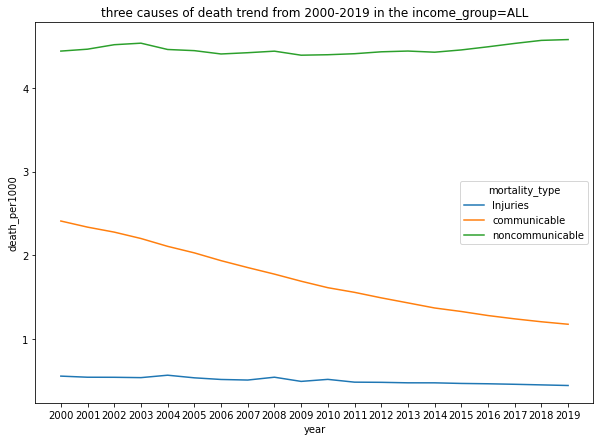

In [35]:
deathtypetrend(global_data_1)

2004


'there death types, it matched the paper1:\n1. When in 2004, Communicable diseases remain an important cause of death in lowincome countries.\n2. Confirm the growing importance of noncommunicable diseases in most low- and middle-income countries.'

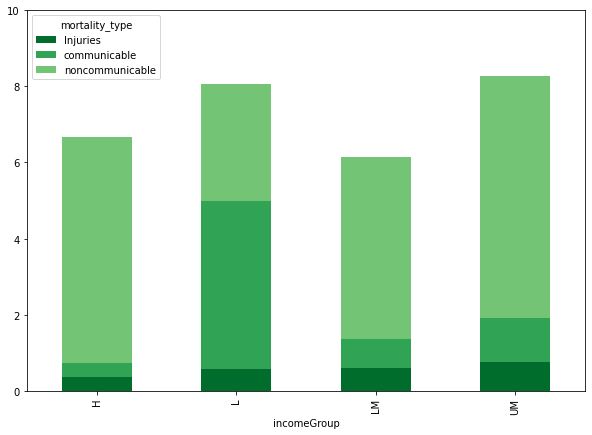

In [36]:

print('2004')
Topdeathtype_incomegroup_year(global_data_1,2004)

'''there death types, it matched the paper1:
1. When in 2004, Communicable diseases remain an important cause of death in lowincome countries.
2. Confirm the growing importance of noncommunicable diseases in most low- and middle-income countries.'''

mortality_type,Injuries,communicable,noncommunicable
year,,,
2000,0.365271,0.440385,6.365222
2001,0.370433,0.379664,6.207204
2002,0.371218,0.394783,6.227248
2003,0.364973,0.406585,6.256538
2004,0.359681,0.379424,5.926381
2005,0.358476,0.410874,5.948071
2006,0.355171,0.381468,5.867346
2007,0.353953,0.385252,5.922796
2008,0.351710,0.394857,5.999267


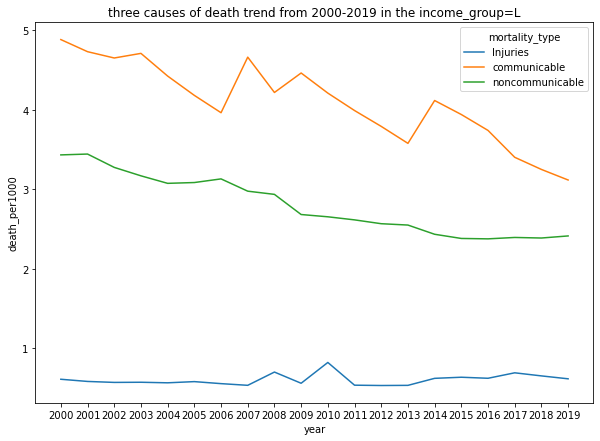

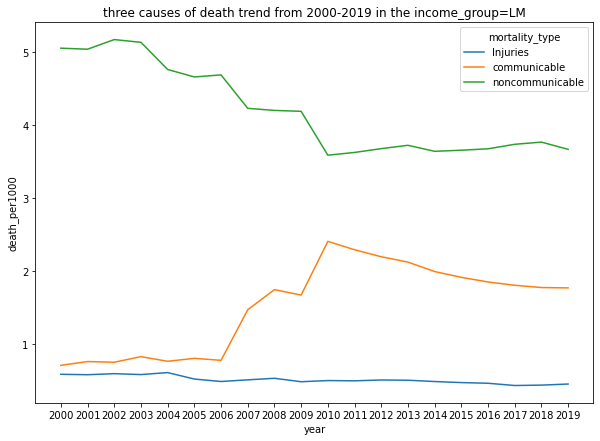

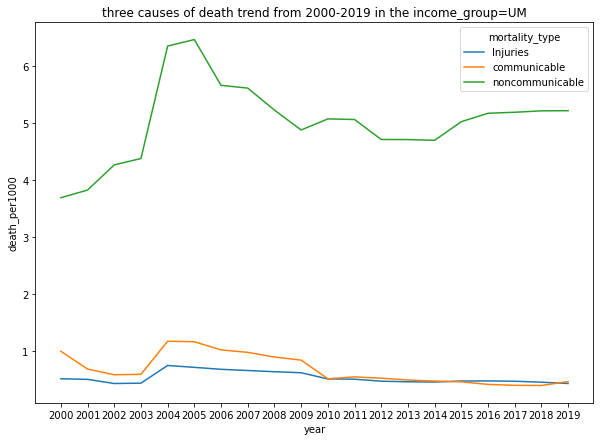

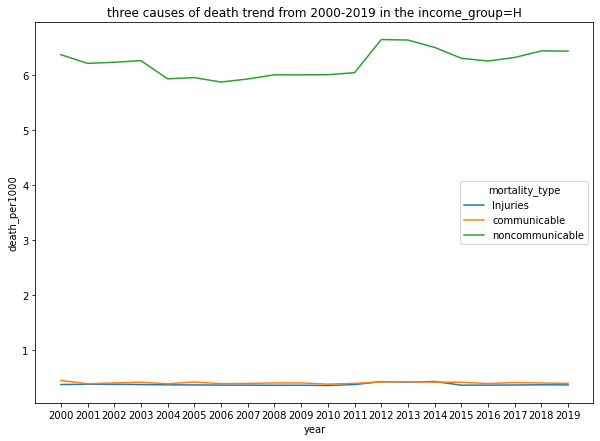

In [37]:

deathtypetrend(global_data_1,income_group='L')
deathtypetrend(global_data_1,income_group='LM')
deathtypetrend(global_data_1,income_group='UM')
deathtypetrend(global_data_1,income_group='H')

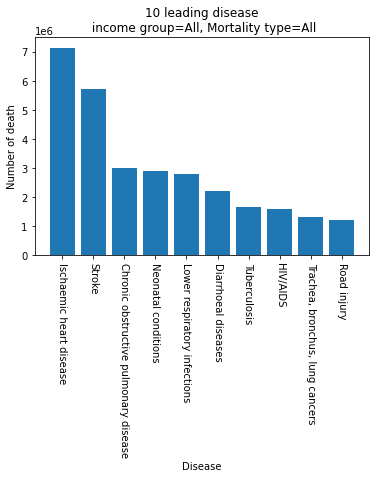


Globally leading specific disease

                               diseaseName    deathNum   mortality_type
39                Ischaemic heart disease  7135937.83  noncommunicable
74                                 Stroke  5709995.44  noncommunicable
14  Chronic obstructive pulmonary disease  2978359.51  noncommunicable
55                    Neonatal conditions  2882799.57     communicable
45           Lower respiratory infections  2771933.93     communicable
23                    Diarrhoeal diseases  2184349.56     communicable
80                           Tuberculosis  1635532.15     communicable
35                               HIV/AIDS  1588609.38     communicable
79        Trachea, bronchus, lung cancers  1305477.90  noncommunicable
68                            Road injury  1204815.87         Injuries


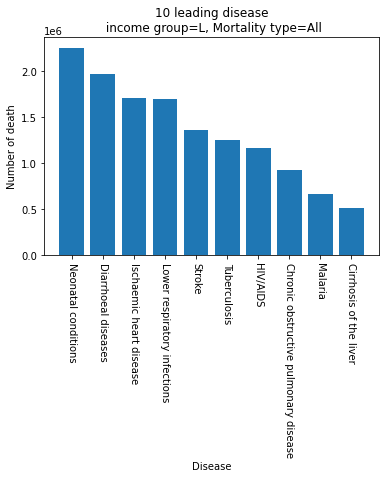



Low-income leading specific disease

                                diseaseName    deathNum   mortality_type
46                    Neonatal conditions  2255907.74     communicable
19                    Diarrhoeal diseases  1973242.15     communicable
32                Ischaemic heart disease  1709846.70  noncommunicable
37           Lower respiratory infections  1692108.82     communicable
64                                 Stroke  1353543.37  noncommunicable
69                           Tuberculosis  1248968.11     communicable
29                               HIV/AIDS  1157212.75     communicable
11  Chronic obstructive pulmonary disease   926314.75  noncommunicable
39                                Malaria   658987.82     communicable
12                 Cirrhosis of the liver   503878.00  noncommunicable


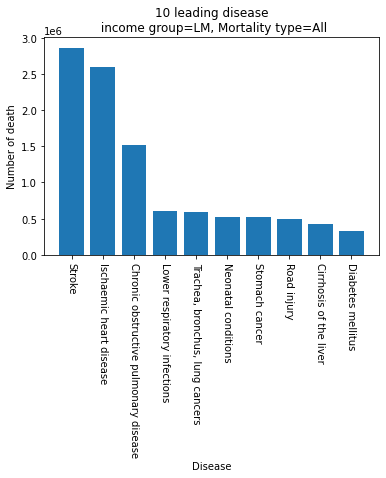



Low-middle income leading specific disease

                               diseaseName    deathNum   mortality_type
66                                 Stroke  2865417.24  noncommunicable
33                Ischaemic heart disease  2602827.33  noncommunicable
11  Chronic obstructive pulmonary disease  1514058.59  noncommunicable
39           Lower respiratory infections   598310.76     communicable
71        Trachea, bronchus, lung cancers   593878.31  noncommunicable
48                    Neonatal conditions   525378.13     communicable
65                         Stomach cancer   522433.03  noncommunicable
60                            Road injury   499816.83         Injuries
12                 Cirrhosis of the liver   426588.86  noncommunicable
19                      Diabetes mellitus   321237.29  noncommunicable


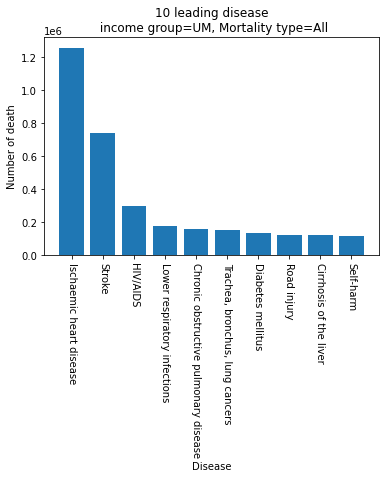



Upper-middle income leading specific disease

                               diseaseName    deathNum   mortality_type
31                Ischaemic heart disease  1255168.82  noncommunicable
63                                 Stroke   737223.40  noncommunicable
27                               HIV/AIDS   293731.64     communicable
37           Lower respiratory infections   174282.27     communicable
10  Chronic obstructive pulmonary disease   156083.72  noncommunicable
66        Trachea, bronchus, lung cancers   151164.66  noncommunicable
16                      Diabetes mellitus   129910.40  noncommunicable
58                            Road injury   121691.66         Injuries
11                 Cirrhosis of the liver   120793.72  noncommunicable
59                              Self-harm   115063.54         Injuries


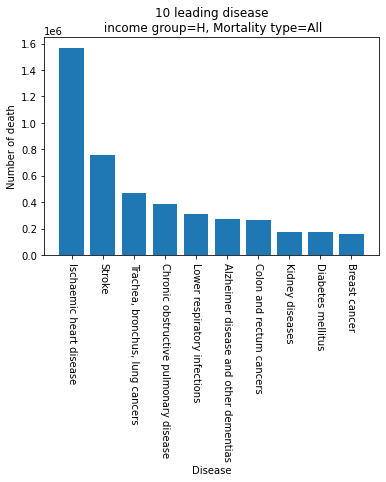



High income leading specific disease

                               diseaseName    deathNum   mortality_type
28                Ischaemic heart disease  1568094.98  noncommunicable
56                                 Stroke   753811.43  noncommunicable
57        Trachea, bronchus, lung cancers   466030.38  noncommunicable
9   Chronic obstructive pulmonary disease   381902.45  noncommunicable
34           Lower respiratory infections   307232.08     communicable
2   Alzheimer disease and other dementias   272209.51  noncommunicable
12               Colon and rectum cancers   261717.11  noncommunicable
30                        Kidney diseases   173914.38  noncommunicable
15                      Diabetes mellitus   172913.19  noncommunicable
6                           Breast cancer   157366.70  noncommunicable


'As may be expected from the very different distributions of deaths by\nage and sex, there are major differences in the ranking of causes\nbetween high- and low-income countries (Table 4). In low-income\ncountries, the dominant causes are infectious and parasitic diseases\n(including malaria), and neonatal causes. In the high-income countries,\n9 of the 10 leading causes of death are non-communicable conditions,\nincluding the four types of cancer. In the middle-income countries, the\n10 leading causes of death are again dominated by non-communicable\nconditions; they also include road traffic accidents as the sixth most\ncommon cause.'

In [38]:
print('\nGlobally leading specific disease\n\n',Topcause_year(global_data_1,2004))

print('\n\nLow-income leading specific disease\n\n ',Topcause_year(global_data_1,2004,income_group='L'))
print('\n\nLow-middle income leading specific disease\n\n',Topcause_year(global_data_1,2004,income_group='LM'))
print('\n\nUpper-middle income leading specific disease\n\n',Topcause_year(global_data_1,2004,income_group='UM'))
print('\n\nHigh income leading specific disease\n\n',Topcause_year(global_data_1,2004,income_group='H'))


'''As may be expected from the very different distributions of deaths by
age and sex, there are major differences in the ranking of causes
between high- and low-income countries (Table 4). In low-income
countries, the dominant causes are infectious and parasitic diseases
(including malaria), and neonatal causes. In the high-income countries,
9 of the 10 leading causes of death are non-communicable conditions,
including the four types of cancer. In the middle-income countries, the
10 leading causes of death are again dominated by non-communicable
conditions; they also include road traffic accidents as the sixth most
common cause.'''

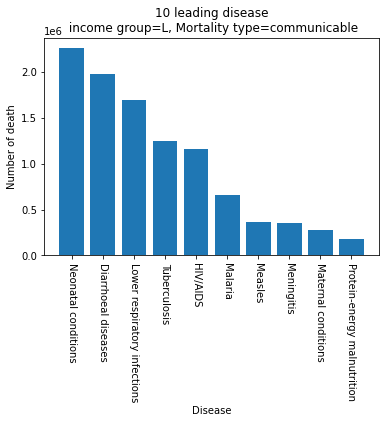

diseaseName,Diarrhoeal diseases,HIV/AIDS,Lower respiratory infections,Malaria,Maternal conditions,Measles,Meningitis,Neonatal conditions,Protein-energy malnutrition,Tuberculosis
year,,,,,,,,,,
2000,1.015594,0.543337,0.796894,0.938300,0.147957,0.237031,0.170082,1.018037,0.128285,0.576768
2001,0.959070,0.568027,0.763997,0.920166,0.140702,0.219014,0.166112,0.982968,0.119967,0.568787
2002,0.918471,0.598421,0.755368,0.897859,0.134066,0.180925,0.160778,0.970733,0.113703,0.566770
2003,0.903979,0.598154,0.756888,0.849126,0.133010,0.222254,0.168113,0.992196,0.088450,0.551010
2004,0.832733,0.594182,0.712837,0.911511,0.125158,0.184958,0.156649,0.950350,0.078808,0.526155
2005,0.787954,0.545888,0.687459,0.824223,0.116477,0.169673,0.152480,0.916936,0.073983,0.505958
2006,0.769804,0.502325,0.678712,0.825716,0.109199,0.107297,0.139485,0.884272,0.116989,0.481826
2007,0.679655,0.929702,0.843052,0.818209,0.156479,0.073064,0.213946,1.004745,0.113873,0.484079
2008,0.553496,0.880727,0.750407,0.621452,0.157162,0.112545,0.206095,0.861129,0.132902,0.477890


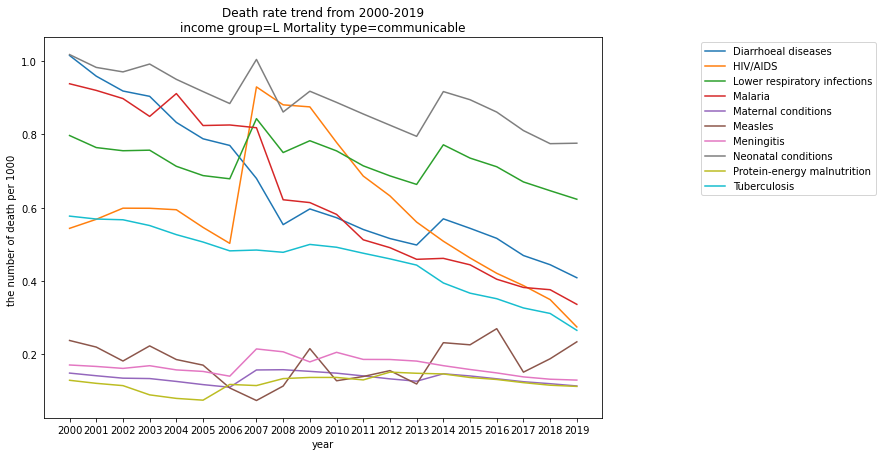

In [39]:
Topcause_trend(global_data_1,2004,income_group='L',category='communicable')

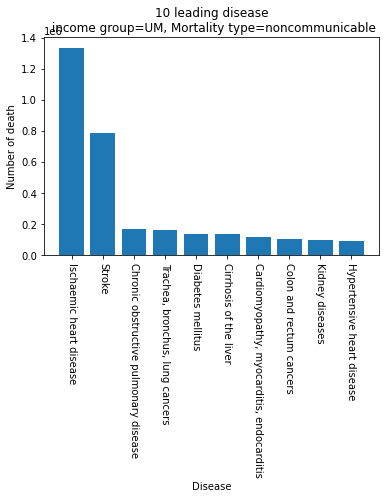

diseaseName,"Cardiomyopathy, myocarditis, endocarditis",Chronic obstructive pulmonary disease,Cirrhosis of the liver,Colon and rectum cancers,Diabetes mellitus,Hypertensive heart disease,Ischaemic heart disease,Kidney diseases,Stroke,"Trachea, bronchus, lung cancers"
year,,,,,,,,,,
2000,0.084658,0.241087,0.152458,0.111938,0.231031,0.108933,1.035816,0.151511,0.621173,0.187986
2001,0.094308,0.254490,0.152815,0.109720,0.219039,0.098518,1.169094,0.155691,0.650464,0.181100
2002,0.089904,0.246862,0.180225,0.194081,0.239661,0.098233,1.393458,0.185880,0.660254,0.228116
2003,0.080397,0.263019,0.180439,0.136245,0.254669,0.108683,1.417670,0.195335,0.663472,0.228919
2004,0.276466,0.271222,0.209899,0.163359,0.225741,0.132579,2.181066,0.162799,1.281049,0.264943
2005,0.293034,0.274918,0.225481,0.167143,0.228349,0.150325,2.217420,0.164221,1.301958,0.271419
2006,0.253180,0.265274,0.193258,0.142879,0.225493,0.152399,1.852111,0.152833,1.135400,0.234342
2007,0.244979,0.270732,0.191394,0.140523,0.230196,0.151973,1.839784,0.156592,1.105661,0.231061
2008,0.249642,0.251713,0.182186,0.133629,0.224412,0.153723,1.698171,0.158564,1.001805,0.217172


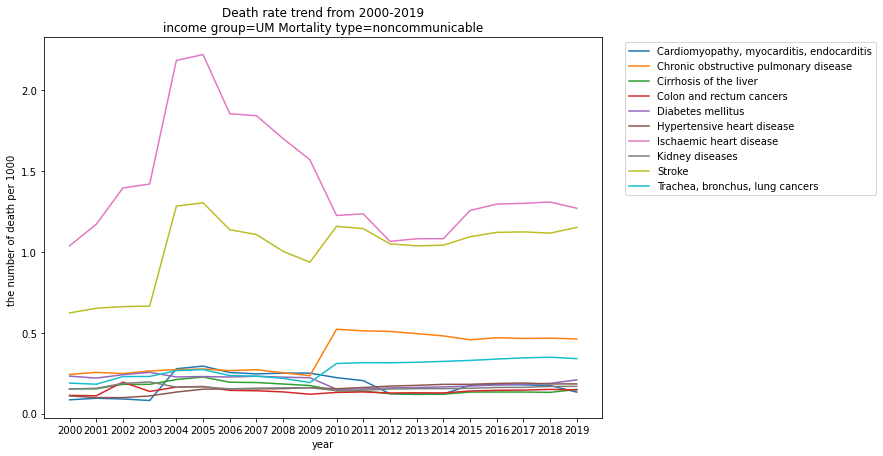

In [40]:
Topcause_trend(global_data_1,2005,income_group='UM',category='noncommunicable')

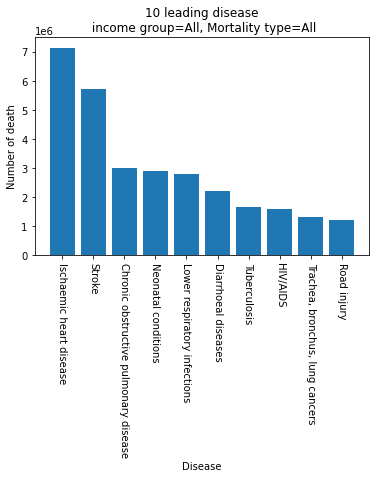

                              diseaseName    deathNum   mortality_type
39                Ischaemic heart disease  7135937.83  noncommunicable
74                                 Stroke  5709995.44  noncommunicable
14  Chronic obstructive pulmonary disease  2978359.51  noncommunicable
55                    Neonatal conditions  2882799.57     communicable
45           Lower respiratory infections  2771933.93     communicable
23                    Diarrhoeal diseases  2184349.56     communicable
80                           Tuberculosis  1635532.15     communicable
35                               HIV/AIDS  1588609.38     communicable
79        Trachea, bronchus, lung cancers  1305477.90  noncommunicable
68                            Road injury  1204815.87         Injuries


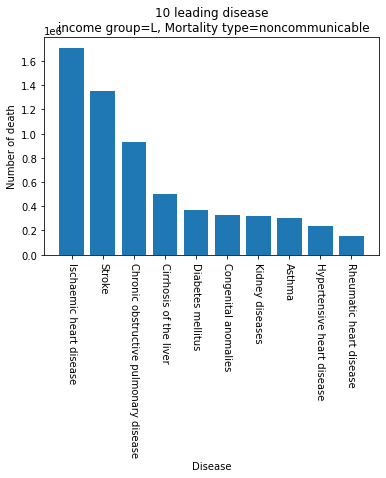

                              diseaseName    deathNum   mortality_type
16                Ischaemic heart disease  1709846.70  noncommunicable
35                                 Stroke  1353543.37  noncommunicable
8   Chronic obstructive pulmonary disease   926314.75  noncommunicable
9                  Cirrhosis of the liver   503878.00  noncommunicable
12                      Diabetes mellitus   364865.70  noncommunicable
11                   Congenital anomalies   329583.95  noncommunicable
17                        Kidney diseases   322315.14  noncommunicable
2                                  Asthma   305313.52  noncommunicable
15             Hypertensive heart disease   233035.13  noncommunicable
31                Rheumatic heart disease   154884.45  noncommunicable


In [41]:
print(Topcause_year(global_data_1,2004))
print(Topcause_year(global_data_1,2004,income_group='L',category='noncommunicable'))

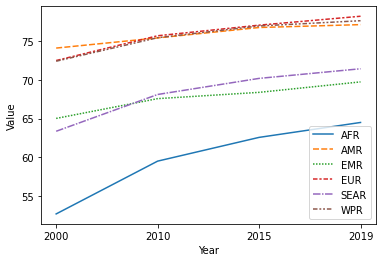

In [42]:
lineplot_time(LifeExpectancy_1)


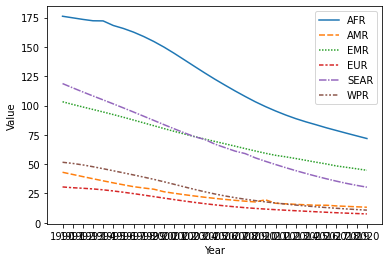

In [43]:
# Sub-Saharan Africa is part of African Region AFRO.
lineplot_time(Under5_Mortality_1)

In [44]:
Under5_Mortality_1[(Under5_Mortality_1['TimeDim'] == 2010) & (Under5_Mortality_1['SpatialDimType'] == "COUNTRY")& (Under5_Mortality_1['Dim1'] == "BTSX")][['NumericValue','SpatialDim']]

,NumericValue,SpatialDim
802,87.75619,AFG
925,120.35612,AGO
1054,13.25660,ALB
1162,4.50005,AND
1345,8.65764,ARE
...,...,...
35326,19.34816,WSM
35506,58.79103,YEM
35647,51.98301,ZAF
35850,79.01105,ZMB


In [45]:
# 2010: country mortality
countryInfoAll[countryInfoAll['CountryCode'] == 'HTI']

,Country,Region,CountryCode,Year,incomeGroup,che_gdp
1280,Haiti,Latin America & Caribbean,HTI,2000,L,3.959640
1281,Haiti,Latin America & Caribbean,HTI,2001,L,3.730882
1282,Haiti,Latin America & Caribbean,HTI,2002,L,3.405104
1283,Haiti,Latin America & Caribbean,HTI,2003,L,3.414277
1284,Haiti,Latin America & Caribbean,HTI,2004,L,3.447301
1285,Haiti,Latin America & Caribbean,HTI,2005,L,3.368438
1286,Haiti,Latin America & Caribbean,HTI,2006,L,3.531488
1287,Haiti,Latin America & Caribbean,HTI,2007,L,3.728293
1288,Haiti,Latin America & Caribbean,HTI,2008,L,3.792944
1289,Haiti,Latin America & Caribbean,HTI,2009,L,3.604476


In [46]:

Under5_Mortality = formatWithSex('Under5_Mortality', Under5_Mortality_1)
LifeExpectancy = formatWithSex('LifeExpectancy', LifeExpectancy_1)
Under5_Mortality

,countrycode,year,Under5_Mortality_BTSX,Under5_Mortality_FMLE,Under5_Mortality_MLE
0,AFG,1957,377.84123,NaN,NaN
1,AFG,1958,370.90156,NaN,NaN
2,AFG,1959,364.40799,NaN,NaN
3,AFG,1960,358.20515,NaN,NaN
4,AFG,1961,352.21199,343.73110,359.77775
...,...,...,...,...,...
12004,ZWE,2016,58.66147,53.50827,63.56478
12005,ZWE,2017,57.04974,51.93884,61.91988
12006,ZWE,2018,54.84205,49.82213,59.56721
12007,ZWE,2019,54.23561,49.32882,58.92604


In [47]:
MaternalMortalityRatio = formatWithoutSex(MaternalMortalityRatio_1)

<AxesSubplot:xlabel='year', ylabel='MaternalMortalityRatio'>

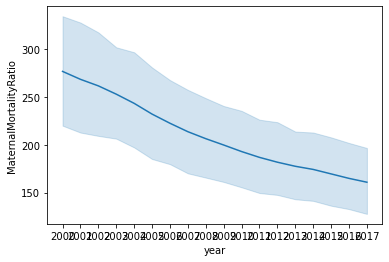

In [48]:
MaternalMortalityRatio = MaternalMortalityRatio.sort_values('year')
sns.lineplot(data=MaternalMortalityRatio, x="year", sort=False,y="MaternalMortalityRatio")

In [49]:
InfoAll = countryInfoAll.merge(LifeExpectancy, left_on=['CountryCode','Year'], right_on=['countrycode','year'], how= 'left')
InfoAll = InfoAll.merge(Under5_Mortality, left_on=['CountryCode','Year'], right_on=['countrycode','year'], how= 'left')
InfoAll = InfoAll.merge(MaternalMortalityRatio, left_on=['CountryCode','Year'], right_on=['countrycode','year'], how= 'left')
InfoAll = InfoAll[['Country','Region','CountryCode','Year','incomeGroup','che_gdp','LifeExpectancy_BTSX','LifeExpectancy_FMLE','LifeExpectancy_MLE','Under5_Mortality_BTSX','Under5_Mortality_FMLE','Under5_Mortality_MLE','MaternalMortalityRatio']]

### all data includes health expendure, three factors, year, incomegroup, and region for each country

###### anova table shows that all three factors were related to health expenditure, of which the region has the most significant correlation

In [50]:
model = ols('che_gdp ~ Year+incomeGroup+Region', data=InfoAll).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Year,303.340452,19.0,2.503468,3.192007e-04
incomeGroup,1527.263417,4.0,59.871376,8.014869e-49
Region,1500.962635,6.0,39.226893,2.975714e-46
Residual,20375.373572,3195.0,NaN,NaN


In [51]:
yearexp = InfoAll[['che_gdp','Year']].dropna()
pearsonr(yearexp['che_gdp'], yearexp['Year'])

(0.11329528204354981, 1.1022013594640358e-10)

In [52]:
InfoAll2015_ = InfoAll.loc[(InfoAll["Year"] == 2015) | (InfoAll["Year"] == 2016) | (InfoAll["Year"] == 2017) | (InfoAll["Year"] == 2018) | (InfoAll["Year"] == 2019)]
d = InfoAll2015_[['Region','Year','che_gdp']]
d = d.dropna()
d = d.pivot_table(index='Region', columns='Year',values = 'che_gdp', aggfunc='mean')
d

Year,2015,2016,2017,2018,2019
Region,,,,,
East Asia & Pacific,6.809137,6.669258,6.673334,6.739615,7.210822
Europe & Central Asia,7.628844,7.650285,7.588706,7.589544,7.735785
Latin America & Caribbean,6.853407,6.848583,6.876387,6.998009,7.110047
Middle East & North Africa,5.456460,5.490857,5.576039,5.565831,5.542898
North America,10.733205,11.022961,10.835383,10.806375,10.844478
South Asia,5.103873,5.479239,5.223773,5.265578,5.286553
Sub-Saharan Africa,5.960786,5.840205,5.684228,5.676715,5.551029


###### correlation between independent var = region and dependent var = che_gdp in Year 2019

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


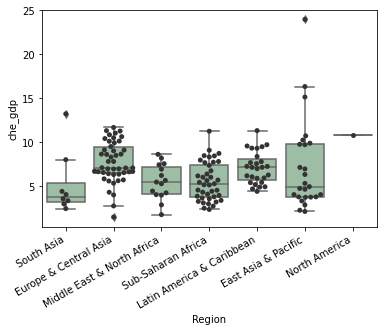

In [53]:
# CAN is only country in North America
ax = sns.boxplot(x='Region', y='che_gdp', data= InfoAll[InfoAll['Year'] == 2019], color='#99c2a2')
# sns.set(rc={'figure.figsize':(16,11)})
ax = sns.swarmplot(x="Region", y="che_gdp", data=  InfoAll[InfoAll['Year'] == 2019],color=".2")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, ha="right")

plt.show()
# highest value: Tuvalu in East Asia

##### Effect of Health Expenditure on Selected Health Outcomes

In [59]:
lifeExp_clean = InfoAll[['Country','Region','CountryCode','Year','incomeGroup','che_gdp', 'LifeExpectancy_BTSX']].dropna()
#
Under5_clean = InfoAll[['Country','Region','CountryCode','Year','incomeGroup','che_gdp', 'Under5_Mortality_BTSX']].dropna()
MaternalMortality_clean = InfoAll[['Country','Region','CountryCode','Year','incomeGroup','che_gdp', 'MaternalMortalityRatio']].dropna()


In [55]:
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','Sub-Saharan Africa'))
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','Latin America & Caribbean')) #
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','Europe & Central Asia')) #
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','Middle East & North Africa')) #
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','North America')) #
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','South Asia'))
print(effectOfexp2015before(Under5_clean,'Under5_Mortality_BTSX','East Asia & Pacific'))

(-0.05273386907325078, 0.20671833076973575)
(-0.4179164339961643, 1.4967499397694152e-18)
(-0.4377385676479083, 7.478549328545166e-34)
(-0.18264024249414057, 0.005070690395405787)
(-0.8934616316635844, 7.234990411166803e-06)
(-0.04388444357190594, 0.6370268182400295)
(0.07482459010325876, 0.1497748139582902)


In [58]:
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','Sub-Saharan Africa'))
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','Latin America & Caribbean')) #
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','Europe & Central Asia'))
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','Middle East & North Africa'))
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','North America'))
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','South Asia'))
print(effectOfexp2015after(Under5_clean,'Under5_Mortality_BTSX','East Asia & Pacific'))

(0.06156939736221051, 0.38885774979525406)
(-0.4862107616124712, 2.2546645622071464e-09)
(-0.2670176197170783, 3.5020413090515225e-05)
(-0.4219379370769157, 0.0001629955677646404)
(-0.017347199679069863, 0.9779139671915713)
(0.13045875955951536, 0.4223403112969549)
(0.06635443454214812, 0.46220372858363734)


In [56]:
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','Sub-Saharan Africa'))
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','Latin America & Caribbean')) #
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','Europe & Central Asia'))
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','Middle East & North Africa'))
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','North America'))
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','South Asia'))
print(effectOfexp2015after(lifeExp_clean,'LifeExpectancy_BTSX','East Asia & Pacific'))

(-0.33508812357260476, 0.002539102449363511)
(0.4250678416044668, 0.0016829661955891796)
(0.5973238406976666, 1.0138810739613868e-09)
(0.63455158632821, 0.00016585742208048248)
(1.0, 1.0)
(-0.24369684196681535, 0.3630676080782074)
(0.3235638234832593, 0.036595604558377945)


In [60]:
#todo need to fix the bug: ValueError: x and y must have length at least 2.
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','Sub-Saharan Africa'))
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','Latin America & Caribbean')) #
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','Europe & Central Asia'))
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','Middle East & North Africa'))
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','North America'))
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','South Asia'))
print(effectOfexp2015after(MaternalMortality_clean,'MaternalMortalityRatio','East Asia & Pacific'))

ValueError: x and y must have length at least 2.

In [64]:
lifeExp_clean


,Country,Region,CountryCode,Year,incomeGroup,che_gdp,LifeExpectancy_BTSX
10,Afghanistan,South Asia,AFG,2010,L,8.569672,59.94055
15,Afghanistan,South Asia,AFG,2015,L,10.105348,61.65429
19,Afghanistan,South Asia,AFG,2019,L,13.242202,63.20990
20,Albania,Europe & Central Asia,ALB,2000,LM,7.233370,73.54528
30,Albania,Europe & Central Asia,ALB,2010,UM,4.745796,76.24688
...,...,...,...,...,...,...,...
3255,Zambia,Sub-Saharan Africa,ZMB,2015,LM,4.435102,60.49665
3259,Zambia,Sub-Saharan Africa,ZMB,2019,LM,5.312203,62.45290
3270,Zimbabwe,Sub-Saharan Africa,ZWE,2010,L,10.475839,51.49335
3275,Zimbabwe,Sub-Saharan Africa,ZWE,2015,L,7.452066,58.47603
